# Model Selection 

The objective of this notebook is to build a very first ent to end Machine Learning model to predict the probability of a patient being discharged on a particular day.

We'll use the dataset generated by the `dataset` job of the ETL folder. 

At this instance, the focus won't be on model performance but rather on understanding the value potential of the available data and the speedness of the solution.

In [1]:
%cd /Users/josefinadallavia/Documents/MIM/Tesis/AML-hospital

/Users/josefinadallavia/Documents/MIM/Tesis/AML-hospital


In [2]:
import os
import pandas as pd
from matplotlib import pyplot as plt   
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from thesis_lib.utils import * 
from thesis_lib.modelling.data import *
from thesis_lib.modelling.model import *
import warnings
warnings.filterwarnings('ignore')

/Users/josefinadallavia/opt/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/josefinadallavia/opt/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/josefinadallavia/opt/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [3]:
data = Data().load('data/hospital_dataset')
variables = data.get_variables_dict()
data.get_stats()

Loading dataset:  hospital_train_data.parquet
Loading dataset:  hospital_val_data.parquet
Loading dataset:  hospital_test_data.parquet


dataset_type,train,val,test
n_observations,319150,33482,33309
relative_size,0.82694,0.0867542,0.0863059
n_cols,71,71,71
positives,42697,4555,4507
negatives,276453,28927,28802
positive_prop,0.133783,0.136043,0.135309
negative_prop,0.866217,0.863957,0.864691
min_date,2017-01-01,2018-11-11,2018-11-11
max_date,2018-11-10,2019-11-11,2019-11-11


In [4]:
categorical_features = [
 'images_requester_roles',
 'images_study_types',
 'labos_requester_roles',
 'sectors_last_sector',
 'sectors_names',
 'surgeries_actual',
 'surgeries_anesthesia_types',
 'surgeries_bact_positive',
 'surgeries_injury_condition',
 'surgeries_post_surgery_condition',
 'surgeries_scheduled',
 'surgeries_scheduled_done',
 'surgeries_services',
 'surgeries_types',
 'gender',
 'insurance_entity',
 'entity_group',
 'origin',
 'admission_sector',
 'isolation',
 'presumptive_dianogsis',
 'responsible_sector',
 'ARM_TEP',
 'CEC_TEP',
 'request_origin',
 'request',
 'request_diagnosis',
 'request_sector']

In [5]:
numerical_features = ['hosp_day_number',
 'images_count',
 'images_cumulative',
 'images_emergencies',
 'images_requester_roles_count',
 'images_requesters_count',
 'images_study_types_count',
 'labos_count',
 'labos_cumulative',
 'labos_emergencies',
 'labos_requester_roles_count',
 'labos_requesters_count',
 'labos_set_count',
 'labos_set_cumulative',
 'sectors_count',
 'sectors_last_stay',
 'surgeries_count',
 'surgeries_cumulative',
 'surgeries_post_surgery_duration',
 'surgeries_pre_surgery_duration',
 'surgeries_prep_duration',
 'surgeries_services_count',
 'surgeries_surgery_delay',
 'surgeries_surgery_duration',
 'surgeries_types_count',
 'emergency_service',
 'new_born_weight',
 'new_born_gestation_age',
 'PIM2TEP',
 'high_risk_TEP',
 'low_risk_TEP',
 'patient_age']

In [6]:
model_params = {'classifier': 'lgbm',
               'accepts_sparse': True,
                'categorical_features' : categorical_features ,
                'numerical_features' : numerical_features,
               'scale_numerical': False}

In [7]:
lgbm_extra_features = Model(**model_params)
lgbm_extra_features.transform(data)

Fitting pipeline...
	 Preprocessing data
	 Preprocessing data
	 Encoding Categorical Features with OneHotEncoding
Transforming data...
	 Transforming numerical features
	 Preprocessing data
	 Transforming categorical features
	 Preprocessing data
	 Transforming numerical features
	 Preprocessing data
	 Transforming categorical features
	 Preprocessing data


### Baseline

In [8]:
len(lgbm_extra_features.model_features)

26723

In [9]:
%%time
lgbm_extra_features.fit_classifier()

Training classifier
[10]	training_set's auc: 0.852829	validation_set's auc: 0.846827
[20]	training_set's auc: 0.859044	validation_set's auc: 0.851045
[30]	training_set's auc: 0.862818	validation_set's auc: 0.853847
[40]	training_set's auc: 0.865905	validation_set's auc: 0.856314
[50]	training_set's auc: 0.867948	validation_set's auc: 0.8577
[60]	training_set's auc: 0.869435	validation_set's auc: 0.858417
[70]	training_set's auc: 0.870673	validation_set's auc: 0.859197
[80]	training_set's auc: 0.871562	validation_set's auc: 0.859617
[90]	training_set's auc: 0.872586	validation_set's auc: 0.859783
[100]	training_set's auc: 0.873331	validation_set's auc: 0.86
CPU times: user 43.5 s, sys: 272 ms, total: 43.7 s
Wall time: 11.9 s


In [11]:
lgbm_extra_features.get_performance_metrics()

training AUC ROC score:  0.8733307286751152
validation AUC ROC score:  0.8599997108433406
relative over-fitting:  0.015264569760414123


### Fine tuning

In [12]:
lgbm_param_grid = {'max_depth': [3,7,10,15,30],
                  'learning_rate': [0.1,0.05,0.01,0.001,0.0001],
                  'num_iterations': [50,100,150,200,300]}

In [13]:
lgbm_extra_features.optimize_hyperparams(params_dict=lgbm_param_grid,
                                         n_folds=3,n_iter=3,
                                         search_type='grid')

Fitting 3 folds for each of 125 candidates, totalling 375 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    9.6s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:   24.7s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:  1.4min
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:  2.4min
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:  3.6min
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:  5.7min
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:  7.6min
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed: 10.3min
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed: 13.8min
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed: 17.4min
[Parallel(n_jobs=2)]: Done  81 tasks      | elapsed: 21.0min
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed: 23.3min
[Parallel(n_jobs=2)]: Done 109 tasks      | elapsed: 27.6min
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed: 32.1min
[Parallel(n_jobs=2)]: Done 141 tasks      | elapsed: 37.8min
[Parallel(

{'mean_fit_time': array([ 8.67244061, 10.51720993, 23.67405645, 25.70037095, 29.49794102,
        13.78426512, 18.27505644, 24.73973695, 32.19317166, 47.77670821,
        13.22746833, 20.14808679, 27.14988573, 32.51295789, 46.40597939,
        13.27574492, 26.79248905, 53.41190696, 43.8831799 , 64.4103272 ,
        11.46963175, 40.32080102, 31.553267  , 50.68108702, 61.4646372 ,
         7.97666669, 10.43438673, 15.04057129, 19.14840674, 28.2462817 ,
        12.07172362, 20.12966665, 27.68273973, 34.47075836, 54.17716622,
        20.86810478, 36.54899748, 32.94789354, 32.46000282, 57.6768678 ,
        18.68389869, 27.95701838, 32.37999074, 46.58727487, 74.76194334,
        15.35876298, 26.76791135, 29.95263179, 43.33216699, 81.53296892,
         6.98436228, 12.3844614 , 16.07507404, 22.74232626, 35.70603577,
        16.22874244, 28.52069863, 40.9131457 , 46.31902599, 60.61469038,
        10.26129699, 22.66471306, 43.30497535, 42.91942143, 70.1590844 ,
        13.46399021, 37.66469359, 

In [14]:
exp_results = lgbm_extra_features.get_model_selection_results()

In [15]:
exp_results.to_csv('experiments/extra_Features_model/lgb_extra_features_grid_search_results.csv')

In [16]:
exp_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_num_iterations,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,8.672441,1.993079,0.313295,0.073078,0.1,3,50,0.847507,0.851407,0.836278,0.845064,0.006414,71
1,10.517210,2.758312,0.371965,0.024863,0.1,3,100,0.855731,0.858430,0.844436,0.852866,0.006062,56
2,23.674056,9.122502,0.703925,0.192260,0.1,3,150,0.859214,0.861535,0.848040,0.856263,0.005891,46
3,25.700371,3.765584,0.797874,0.060000,0.1,3,200,0.861171,0.863255,0.849722,0.858050,0.005949,41
4,29.497941,0.863805,1.233758,0.205889,0.1,3,300,0.863767,0.865422,0.851591,0.860260,0.006167,37
...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,16.458552,4.158780,0.302195,0.089563,0.0001,30,50,0.834995,0.838790,0.820223,0.831336,0.008009,104
121,31.514947,0.787198,0.511887,0.047445,0.0001,30,100,0.835290,0.839225,0.822677,0.832397,0.007059,100
122,42.252062,8.467677,0.741733,0.100903,0.0001,30,150,0.835612,0.840005,0.824787,0.833468,0.006395,96
123,48.128804,5.840884,1.062736,0.130783,0.0001,30,200,0.836188,0.841254,0.824984,0.834142,0.006798,93


In [17]:
best_params = lgbm_extra_features.model_selection.best_params_
best_params

{'learning_rate': 0.05, 'max_depth': 30, 'num_iterations': 300}

In [18]:
best_params = {'learning_rate': 0.01, 'max_depth': 10, 'num_iterations': 250}

### Optimized

In [19]:
%%time
lgbm_extra_features.fit_best_classifier()

Training classifier
[10]	training_set's auc: 0.851135	validation_set's auc: 0.845472
[20]	training_set's auc: 0.855501	validation_set's auc: 0.848523
[30]	training_set's auc: 0.858346	validation_set's auc: 0.850839
[40]	training_set's auc: 0.860312	validation_set's auc: 0.852417
[50]	training_set's auc: 0.862343	validation_set's auc: 0.853922
[60]	training_set's auc: 0.864049	validation_set's auc: 0.85527
[70]	training_set's auc: 0.865841	validation_set's auc: 0.85657
[80]	training_set's auc: 0.867302	validation_set's auc: 0.85763
[90]	training_set's auc: 0.868568	validation_set's auc: 0.858633
[100]	training_set's auc: 0.869684	validation_set's auc: 0.859558
[110]	training_set's auc: 0.870668	validation_set's auc: 0.86009
[120]	training_set's auc: 0.87161	validation_set's auc: 0.860579
[130]	training_set's auc: 0.872475	validation_set's auc: 0.860975
[140]	training_set's auc: 0.873204	validation_set's auc: 0.861363
[150]	training_set's auc: 0.873917	validation_set's auc: 0.861579
[160

In [20]:
lgbm_extra_features.get_performance_metrics()

training AUC ROC score:  0.8815239175834568
validation AUC ROC score:  0.8633341728489713
relative over-fitting:  0.02063443132019552


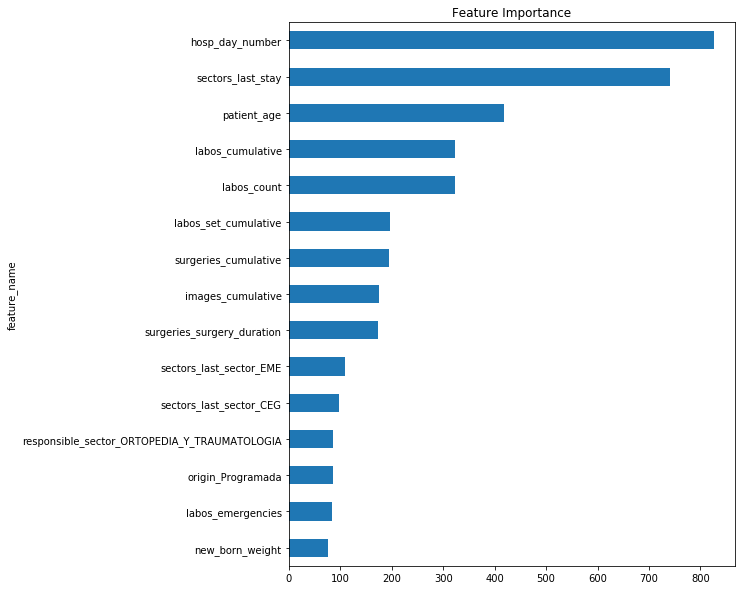

In [21]:
lgbm_extra_features.plot_feature_importance(15)

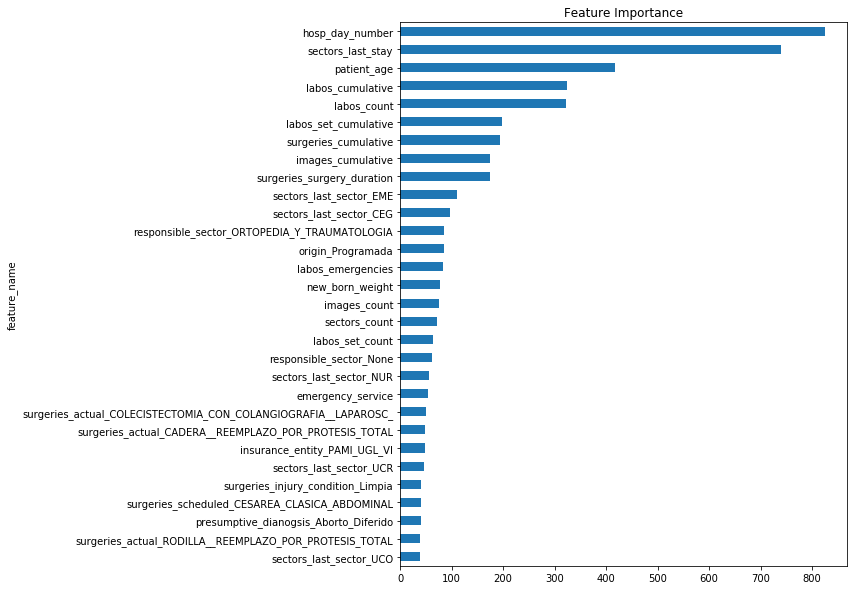

In [24]:
lgbm_extra_features.plot_feature_importance(30)

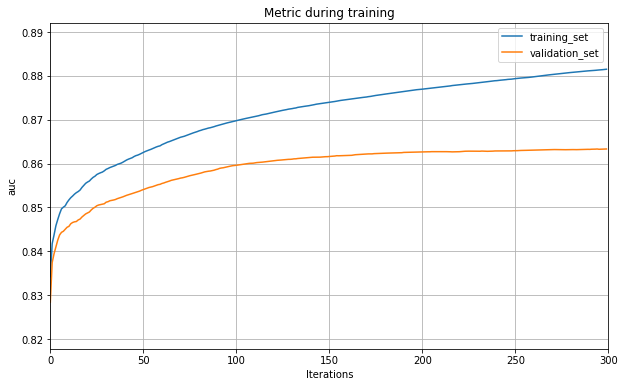

In [22]:
import lightgbm as lgb 
lgb.plot_metric(lgbm_extra_features.classifier.evals_result, 'auc', figsize=(10,6))

In [23]:
import pickle
outputfile ='experiments/extra_Features_model/lgbm_extra_features_optimized.pkl'
with open(outputfile, 'wb') as pickle_file:
    pickle.dump(lgbm_extra_features, pickle_file)